# Current Source Density Analysis
Current source density analysis (CSD) is a method of analysis of extracellular electric potential measurments recorded at multiple sites which produces estimates of current sources generating the measured potentials. Here, it is applied to our Ecephys Local Field Potential (LFP) measurements along a neuropixel probe to visualize how activity moves through the brain over time. In this notebook, we use **[Elephant](https://elephant.readthedocs.io/)**, an Electrophysiology Library for CSD Analysis.

It is typically more useful to view CSD as an average across many stimulus trials for more visible results. In this notebook, stimulus times are used to average the LFP responses of several trials. To do this, the relevant stimulus times are selected from the `stimulus table`, then the LFP data is interpolated. Next, time windows of the trials are taken from the LFP data and averaged. Finally, the average LFP response is used as input to the CSD calculation.

### Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quantities as pq

from dandi import dandiapi
from elephant.current_source_density import generate_lfp, estimate_csd
from math import sqrt
from neo import AnalogSignal
from pynwb import NWBHDF5IO
from scipy import interpolate

### Downloading Ecephys File
For our data, we separate the LFP data for each probe into their own files since they are so large. The example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. To specify your own file to use, set `dandiset_id` and `dandi_filepath` to be the respective dandiset id and dandi filepath of the file you're interested in. When accessing an embargoed dataset, change `authenticate` to True and set `dandi_api_key` to be your DANDI API key.

In [2]:
dandiset_id = "000021"
dandi_stim_filepath = "sub-730756767/sub-730756767_ses-757970808.nwb"
dandi_lfp_filepath = "sub-730756767/sub-730756767_ses-757970808_probe-769322852_ecephys.nwb"
download_loc = "."

authenticate = False
dandi_api_key = ""

In [3]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.51.0) of dandi/dandi-cli is available. You are using 0.46.6


Got dandiset DANDI:000021/draft


In [4]:
stim_filename = dandi_stim_filepath.split("/")[-1]
lfp_filename = dandi_lfp_filepath.split("/")[-1]
stim_filepath = f"{download_loc}/{stim_filename}"
lfp_filepath = f"{download_loc}/{lfp_filename}"

In [5]:
file = my_dandiset.get_asset_by_path(dandi_stim_filepath)
# this may take awhile, especially if the file to download is large
file.download(dandi_stim_filepath)

print(f"Downloaded file to {stim_filepath}")

Downloaded file to ./sub-730756767_ses-757970808.nwb


In [6]:
file = my_dandiset.get_asset_by_path(dandi_lfp_filepath)
# this may take awhile, especially if the file to download is large
file.download(dandi_lfp_filepath)

print(f"Downloaded file to {lfp_filepath}")

Downloaded file to ./sub-730756767_ses-757970808_probe-769322852_ecephys.nwb


### Reading LFP Data and Stimulus Data
Here, we read in the stimulus NWB file and the LFP NWB files. The LFP data is read from this file's probe data section. The `LFP` object contains a `data` array and a `timestamps` array which will be used.

In [7]:
io = NWBHDF5IO(stim_filepath, mode="r", load_namespaces=True)
stim_nwb = io.read()

io = NWBHDF5IO(lfp_filepath, mode="r", load_namespaces=True)
lfp_nwb = io.read()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [8]:
lfp = lfp_nwb.acquisition["probe_769322852_lfp_data"]
lfp

probe_769322852_lfp_data pynwb.ecephys.ElectricalSeries at 0x1962443235136
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (12085040, 89), type "<f4">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (12085040,), type "<f8">
  timestamps_unit: seconds
  unit: volts

### Extracting Stimulus Times
First, you must take a stimulus table from your stimulus file. Since your stimulus table will be unique to your experiment, you'll have to use some ingenuity to extract the timestamps that are of interest to you. Below, the stimulus names of are displayed. Set `stim_name` to be the name that contains the associated stimulus table you want. Then we display the stimulus table. You can see that it contains the `start_time` of each stimulus event. Below, you can define `stim_select` to select individual rows of the table based on these properties. `stim_times` should be a list of timestamps.

In [9]:
stim_nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [10]:
stim_name = "flashes_presentations"
stim_table = stim_nwb.intervals[stim_name]
stim_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1285.577251,1285.827445,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1287.578841,1287.829058,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1289.580531,1289.830745,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1291.582241,1291.832440,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1293.583911,1293.834113,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1295.585541,1295.835753,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1297.587271,1297.837468,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1299.588921,1299.839125,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1301.590591,1301.840795,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


In [11]:
### select start times from table that fit certain critera here

stim_select = lambda row: True
all_stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]
len(all_stim_times)

150

### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory to the following interpolation. This can be mitigated in two ways. Firstly, the `interp_hz` variable in the following section can be decreased. Otherwise, the analysis can be performed with some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice.

In [12]:
print(all_stim_times[0])
print(all_stim_times[-1])
print(lfp.timestamps[0])
print(lfp.timestamps[-1])

1285.5772508695136
1583.8263808695135
3.727534675412933
9671.771044169622


In [13]:
# period_start = lfp.timestamps[0]
period_start = 1280
# period_end = lfp.timestamps[-1]
period_end = 1590

In [14]:
# filter stim_timestamps to just timestamps within period
stim_times = np.array([ts for ts in all_stim_times if ts >= period_start and ts <= period_end])
if len(stim_times) == 0:
    raise ValueError("There are no stimulus timestamps in that period")

In [15]:
# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = None, None
for i, ts in enumerate(lfp.timestamps):
    if not period_start_idx and ts >= period_start:
        period_start_idx = i
    if period_start_idx and ts >= period_end:
        period_end_idx = i
        break

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

In [16]:
print(stim_times.shape)
print(lfp_timestamps.shape)
print(lfp_data.shape)

(150,)
(387500,)
(387500, 89)


### LFP Interpolation
Because we cannot be certain that the LFP trace is at a perfectly regular Hz, we will interpolate it to be able to compare stimulus timestamps to their approximate LFP times. After you have a valid list of stimulus timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the LFP data along it, making interpolated LFP data called `interp_lfp`. This should be a 2D array with dimensions `time` and `channel`, where channels are the different measurement channels along the probe. Here, the timestamps are interpolated to 250 Hertz, but you can change this by setting `interp_hz`.

In [17]:
interp_hz = 250

In [18]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(387500,)
(387500, 89)


In [19]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(lfp_timestamps[0], lfp_timestamps[-1], step=(1/interp_hz))
interp_channels = []

# interpolate channel by channel to save RAM
for channel in range(lfp_data.shape[1]):
    f = interpolate.interp1d(lfp_timestamps, lfp_data[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_channels.append(f(time_axis))

interp_lfp = np.transpose(interp_channels)

print(interp_lfp.shape)

(77500, 89)


### Getting Stimulus Time Windows
Now that you have your interpolated LFP data, you can use the stimulus times to identify the windows of time in the LFP data that exist around a stimulus event. Since the LFP data have been interpolated, we can easily translate timestamps to indices within the LFP trace array. Set `window_start_time` to be a negative number, representing the seconds before the stimulus event and `window_end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_lfp` trace by using `interp_hz` to convert seconds to array indices. These will be averaged out for each measurement channel, and a confidence interval will be calculated.

In [20]:
window_start_time = -0.05
window_end_time = 0.2

In [21]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - lfp_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > len(interp_lfp):
        continue
        
    windows.append(interp_lfp[start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows)
print(windows.shape)

(150, 62, 89)


In [22]:
# get average of all windows
average_trace = np.average(windows, axis=0)
print(average_trace.shape)

(62, 89)


### Using Elephant to Estimate CSD
**Elephant** takes input in the form of a **Neo** *AnalogSignal*. Before analysis, we create the *AnalogSignal* object with the LFP trace as input, in addition to the `hz` valueas the `sampling_rate` of the data, and a list of numbers, `coords` representing the channels of the LFP data. After this, it is as simple as calling `estimate_csd`.

In [23]:
coords = [(elem,) for elem in range(average_trace.shape[1])]
neo_lfp = AnalogSignal(average_trace, units="V", sampling_rate = interp_hz*pq.Hz)
neo_lfp.annotate(coordinates = coords * pq.mm)

In [24]:
# this takes a while
csd = np.array(estimate_csd(neo_lfp, method="KCSD1D"))
csd.shape

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876


(62, 100)

### Displaying Current Source Density
The current source density over time can be shown below with **matplotlib's** `imshow` method.

Text(0, 0.5, 'Approximate distance along probe (μm), \n[low values toward surface]')

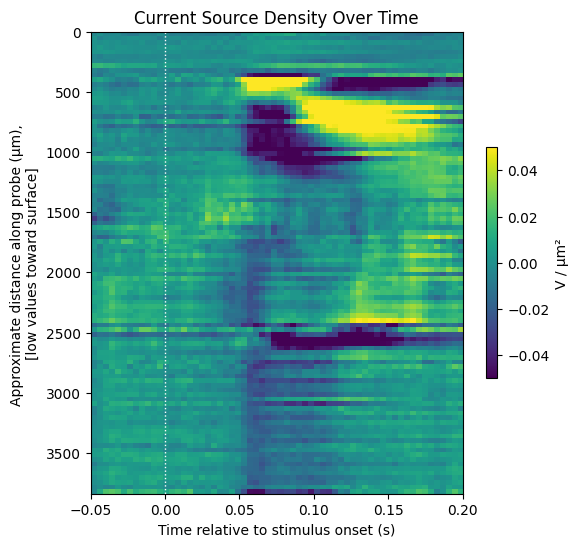

In [25]:
fig, ax = plt.subplots(figsize=(6,6))

img = ax.imshow(csd.transpose()[::-1], 
                extent=[window_start_time, window_end_time, 3840, 0], # probe is 3840 micrometers 
                aspect="auto",
                vmin=-0.05,
                vmax=0.05
               ) # set vmin and vmax here as needed

# make dotted line at stimulus onset
ax.plot([0,0],[0, 3840], ':', color='white', linewidth=1.0)

cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("V / μm²")

ax.set_title("Current Source Density Over Time")
ax.set_xlabel("Time relative to stimulus onset (s)")
ax.set_ylabel("Approximate distance along probe (μm), \n[low values toward surface]")